## Setup

In [1]:
#!pip install pyarrow
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn

In [34]:
SEED = 10

## Read the data in

In [35]:
import pyarrow.parquet as pq
import pandas as pd

f = '/Users/siddharthsachdeva/Downloads/weekly-fd.parquet'
pdf = pd.read_parquet(f)

In [36]:
pdf.head()

,left_crop_url,right_crop_url,camera_metadata,left_crop_metadata,right_crop_metadata,pen_id,group_id,annotation_state_id,distance_from_camera
0,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10152310499139117, ""focalLength...","{""width"": 2224, ""height"": 1468, ""x_coord"": 576...","{""width"": 2284, ""height"": 1507, ""x_coord"": 0, ...",57,57,6,0.659820
1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10152162251919987, ""focalLength...","{""width"": 2733, ""height"": 1046, ""x_coord"": 751...","{""width"": 2461, ""height"": 1027, ""x_coord"": 170...",59,59,6,0.487365
2,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10148368515391534, ""focalLength...","{""width"": 3253, ""height"": 1301, ""x_coord"": 842...","{""width"": 3594, ""height"": 1258, ""x_coord"": 88,...",56,56,6,0.471675
3,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.1017976434480721, ""focalLength""...","{""width"": 2413, ""height"": 1280, ""x_coord"": 162...","{""width"": 2250, ""height"": 1159, ""x_coord"": 114...",60,60,6,0.757097
4,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.1017976434480721, ""focalLength""...","{""width"": 2067, ""height"": 811, ""x_coord"": 1919...","{""width"": 1973, ""height"": 727, ""x_coord"": 1428...",60,60,6,0.686996


In [37]:
pdf.columns

Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
       'annotation_state_id', 'distance_from_camera'],
      dtype='object')

## Filter and preprocess the features

In [38]:
pdf.shape

(2165, 9)

In [39]:
## Filter rows without ground truth depth

pdf = pdf[pdf.distance_from_camera.notnull()]
pdf.shape

(2165, 9)

In [40]:
pdf = pdf[pdf['camera_metadata'].apply(type) == str]
print(pdf['camera_metadata'].apply(type).value_counts())

<class 'str'>    2165
Name: camera_metadata, dtype: int64


In [41]:
pdf = pdf[pdf['left_crop_metadata'].apply(type) == str]
print(pdf['left_crop_metadata'].apply(type).value_counts())

<class 'str'>    2165
Name: left_crop_metadata, dtype: int64


### Expand dict based features into columns

In [42]:
import json

dict_columns = ['left_crop_metadata', 'camera_metadata', 'right_crop_metadata']

for df_col in dict_columns:
    pdf = pdf[pdf[df_col].apply(type) == str]
    expanded = pdf[df_col].apply(json.loads).apply(pd.Series)
    for key in expanded.columns:
        expanded[df_col + '__' + key] = expanded[key]
        expanded.drop(key, inplace=True, axis=1)
    for col in expanded:
        if expanded[col].isnull().sum() > 0:
            print(col + ' is null')
            print(expanded[col].isnull().value_counts())
    pdf = pd.concat([pdf, expanded], axis=1)

left_crop_metadata__depth_mm is null
False    1961
True      204
Name: left_crop_metadata__depth_mm, dtype: int64
right_crop_metadata__depth_mm is null
False    1961
True      204
Name: right_crop_metadata__depth_mm, dtype: int64


In [46]:
pdf.head()

,left_crop_url,right_crop_url,camera_metadata,left_crop_metadata,right_crop_metadata,pen_id,group_id,annotation_state_id,distance_from_camera,left_crop_metadata__width,...,right_crop_metadata__width,right_crop_metadata__height,right_crop_metadata__x_coord,right_crop_metadata__y_coord,right_crop_metadata__depth_mm,right_crop_metadata__crop_area,right_crop_metadata__quality_score,right_crop_metadata__mean_luminance,right_crop_metadata__edge_detection_score,right_crop_metadata__mean_green_luminance
0,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10152310499139117, ""focalLength...","{""width"": 2224, ""height"": 1468, ""x_coord"": 576...","{""width"": 2284, ""height"": 1507, ""x_coord"": 0, ...",57,57,6,0.659820,2224.0,...,2284.0,1507.0,0.0,683.0,430.729355,3193664.0,0.995874,56.217367,0.257412,51.625214
1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10152162251919987, ""focalLength...","{""width"": 2733, ""height"": 1046, ""x_coord"": 751...","{""width"": 2461, ""height"": 1027, ""x_coord"": 170...",59,59,6,0.487365,2733.0,...,2461.0,1027.0,170.0,1551.0,441.474207,2436864.0,0.999192,77.811399,0.229612,59.733311
2,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10148368515391534, ""focalLength...","{""width"": 3253, ""height"": 1301, ""x_coord"": 842...","{""width"": 3594, ""height"": 1258, ""x_coord"": 88,...",56,56,6,0.471675,3253.0,...,3594.0,1258.0,88.0,498.0,310.472723,4403720.0,0.783690,24.787709,0.194479,40.435831
3,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.1017976434480721, ""focalLength""...","{""width"": 2413, ""height"": 1280, ""x_coord"": 162...","{""width"": 2250, ""height"": 1159, ""x_coord"": 114...",60,60,6,0.757097,2413.0,...,2250.0,1159.0,1147.0,1313.0,466.288137,2499456.0,0.997052,48.240970,0.295896,51.281221
4,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.1017976434480721, ""focalLength""...","{""width"": 2067, ""height"": 811, ""x_coord"": 1919...","{""width"": 1973, ""height"": 727, ""x_coord"": 1428...",60,60,6,0.686996,2067.0,...,1973.0,727.0,1428.0,0.0,561.264380,1419088.0,0.862447,47.963678,0.305847,50.996740


### Get a high-level sense of the data

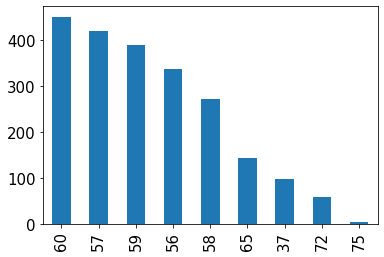

In [47]:
pdf.pen_id.value_counts().plot.bar()

In [48]:
pdf.columns

Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
       'annotation_state_id', 'distance_from_camera',
       'left_crop_metadata__width', 'left_crop_metadata__height',
       'left_crop_metadata__x_coord', 'left_crop_metadata__y_coord',
       'left_crop_metadata__depth_mm', 'left_crop_metadata__crop_area',
       'left_crop_metadata__quality_score',
       'left_crop_metadata__mean_luminance',
       'left_crop_metadata__edge_detection_score',
       'left_crop_metadata__mean_green_luminance', 'camera_metadata__baseline',
       'camera_metadata__focalLength', 'camera_metadata__pixelCountWidth',
       'camera_metadata__focalLengthPixel',
       'camera_metadata__imageSensorWidth',
       'camera_metadata__pixelCountHeight',
       'camera_metadata__imageSensorHeight',
       'camera_metadata__stereoParametersUrl', 'right_crop_metadata__width',
       'right_crop_metadata__height', 'right_crop_metad

In [49]:
pdf.shape

(2165, 37)

## Train a linear regression model

In [50]:
from itertools import combinations

dimension_features = ['width', 'height']
left_dimension_features = ['left_crop_metadata__' + f for f in dimension_features]
all_dimension_features = left_dimension_features + ['right_crop_metadata__' + f for f in dimension_features]

area_features = ['crop_area']
left_area_features = ['left_crop_metadata__' + 'crop_area']
all_dimension_features = left_dimension_features + ['right_crop_metadata__' + 'crop_area']

quality_features = ['edge_detection_score', 'mean_green_luminance', 'mean_luminance', 'quality_score']
camera_features = ['focalLength', 'focalLengthPixel', 'imageSensorHeight', 'imageSensorWidth']

featuregroups = [dimension_features, quality_features, camera_features]
featuresets = [dimension_features, dimension_features + camera_features, dimension_features+camera_features+quality_features]
featuresets

[['width', 'height'],
 ['width',
  'height',
  'focalLength',
  'focalLengthPixel',
  'imageSensorHeight',
  'imageSensorWidth'],
 ['width',
  'height',
  'focalLength',
  'focalLengthPixel',
  'imageSensorHeight',
  'imageSensorWidth',
  'edge_detection_score',
  'mean_green_luminance',
  'mean_luminance',
  'quality_score']]

In [51]:
from sklearn.linear_model import LinearRegression

help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model.base:

class LinearRegression(LinearModel, sklearn.base.RegressorMixin, sklearn.base.MultiOutputMixin)
 |  Ordinary least squares Linear Regression.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean, optional, default True
 |      whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
 |      an estimator with ``normalize=False``.
 |  
 |  copy_X : boolean, optional, default True
 |      If True, X will be copied; e

In [52]:
# !pip install statsmodels

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})

hyperparams = {LinearRegression: {'normalize': True}}

def check_features(featureset):
    for feat in featureset:
        try:
            assert pdf[feat].isnull().sum() == 0
        except:
            print(feat)
            print(pdf[feat].isnull().sum())

def get_performance_report(y_true, y_pred, metrics=[explained_variance_score, mean_absolute_error]):
    report = {'evaluation': {m.__name__: m(y_true, y_pred) for m in metrics}}
    report['preds'] = y_pred
    report['y_true'] = y_true
    report['residuals'] = y_true - y_pred
    return report

def train_and_eval_model(
        df,
        cls, 
        featureset
    ):
    check_features(featureset)
    model = cls(**hyperparams[cls])
    X = df[featureset]
    y = df['distance_from_camera']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=SEED)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    report = get_performance_report(Y_test, pred)
    report['feature_importances'] = {feat: model.coef_[i] for i, feat in enumerate(featureset)}
    return report

def evaluate(cls, featureset, train_pen_specific=True):
    results = dict()
    for pen in pdf.pen_id.unique():
        this_pen_df = pdf[pdf.pen_id==pen]
        results[pen] = train_and_eval_model(this_pen_df, cls, featureset)
    return results

def plot_results(report, is_model=True):
    ncols = 4
    if is_model:
        ncols=5
    nrows = len(report)
    fig, axes = plt.subplots(nrows=len(report), ncols=ncols, figsize=(5*ncols,2.5*nrows))
    for i, pen in enumerate(report):
        overall_title = f"Pen: {pen} MAE {report[pen]['evaluation']['mean_absolute_error']}"
        axes[i, ncols-3].set_title(overall_title + '\n' + 'residual distribution')
        if is_model:
            pd.Series(report[pen]['feature_importances']).plot.bar(ax=axes[i][0])
            axes[i][0].set_title('feature coefficients')
        qqplot(ax=axes[i][ncols-4], data=report[pen]['residuals'], fit=True, line='s')
        axes[i][ncols-4].set_title('QQ Plot')
        axes[i][ncols-2].scatter(report[pen]['residuals'], report[pen]['preds'])
        axes[i][ncols-2].set_title('residuls vs. predicted (test for homoescadicity)')
        pd.Series(report[pen]['residuals']).plot.hist(bins=np.arange(-1, 1, 0.025), ax=axes[i][ncols-3])
        axes[i][ncols-1].scatter(report[pen]['preds'],report[pen]['y_true'])
        axes[i][ncols-1].set_xlabel('preds')
        axes[i][ncols-1].set_ylabel('y_true')
        axes[i][ncols-1].set_xlim([0, 1])
        axes[i][ncols-1].set_ylim([0,1])
        axes[i][ncols-1].set_title('Observed vs predicted')
    fig.tight_layout()

## How good is our baseline right now

Pen:57
{'explained_variance_score': 0.10554225843620002, 'mean_absolute_error': 0.190496966169703}
Pen:59
{'explained_variance_score': 0.12796656765400383, 'mean_absolute_error': 0.17502507970051953}
Pen:56
{'explained_variance_score': 0.17873857681822103, 'mean_absolute_error': 0.21736491862681376}
Pen:60
{'explained_variance_score': 0.05958691242415248, 'mean_absolute_error': 0.1980940499585907}
Pen:58
{'explained_variance_score': 0.2345401110828852, 'mean_absolute_error': 0.19254116836243243}
False    142
Name: left_crop_metadata__depth_mm, dtype: int64
False    58
Name: left_crop_metadata__depth_mm, dtype: int64
Pen:37
{'explained_variance_score': 0.06353601096801376, 'mean_absolute_error': 0.2216651024517111}
False    4
Name: left_crop_metadata__depth_mm, dtype: int64


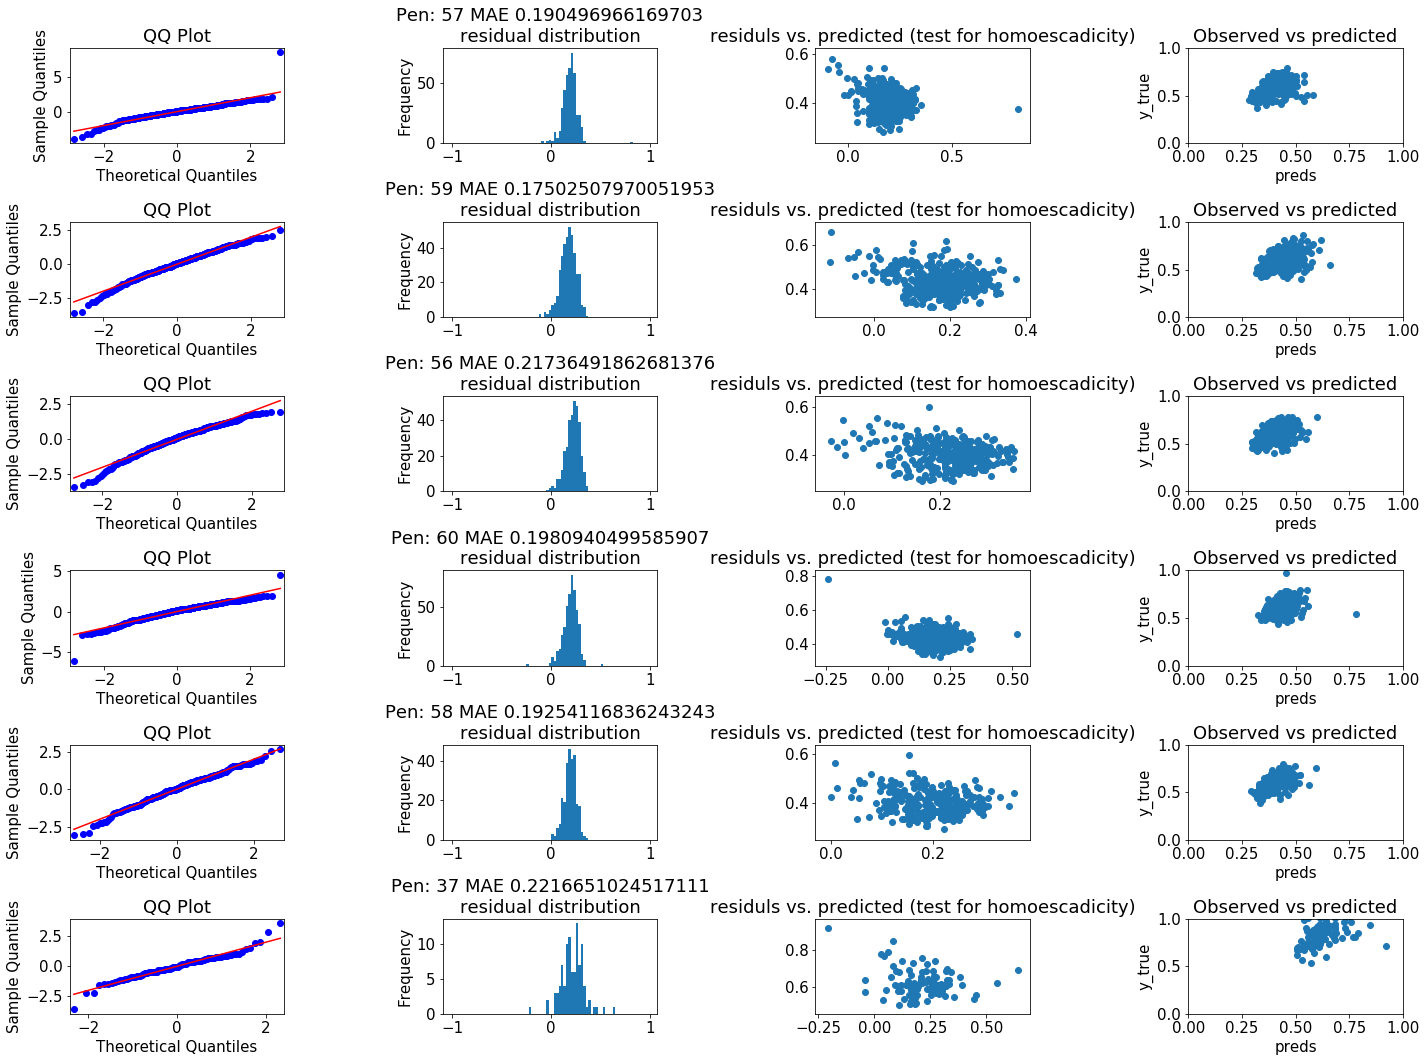

In [56]:
has_depth = pdf[pdf.left_crop_metadata__depth_mm.notnull()]
has_depth_and_distance = pdf[pdf.distance_from_camera.notnull()]

results = dict()
for pen in has_depth_and_distance.pen_id.unique():
    this_pen_df = has_depth_and_distance[pdf.pen_id==pen]
    y_true, y_pred = this_pen_df.distance_from_camera, this_pen_df.left_crop_metadata__depth_mm / 1000
    try:
        assert y_true.isnull().sum() == 0
        assert y_pred.isnull().sum() == 0, str(y_pred.notnull().value_counts())
        results[pen] = get_performance_report(y_true, y_pred)
        print(f'Pen:{pen}')
        print(results[pen]['evaluation'])
    except Exception as e:
        print(e)

plot_results(results, is_model=False)

No cells with both depth_mm and distance_from_camera!!!!

## If we correct the depth_mm calculation to update fish length based on our formula, we can get improved depth estimates as follows.

depth = (focal length x fish length) / pixel length

Solve for fish length and get:

fish length = (pixel length x depth) / focal length

We can then replace depth with the template matching output to get a fish length distribution, and then use the median fish length

In [58]:
import numpy as np
import math

IMAGE_HEIGHT = 'left_crop_metadata__height'
IMAGE_WIDTH = 'left_crop_metadata__width'

print(has_depth_and_distance[IMAGE_HEIGHT])
print(has_depth_and_distance[IMAGE_WIDTH])

0       1468.0
1       1046.0
2       1301.0
3       1280.0
4        811.0
         ...  
2160    1453.0
2161    1390.0
2162    1482.0
2163     925.0
2164    1275.0
Name: left_crop_metadata__height, Length: 2165, dtype: float64
0       2224.0
1       2733.0
2       3253.0
3       2413.0
4       2067.0
         ...  
2160    2091.0
2161    3260.0
2162    2001.0
2163    2416.0
2164    3428.0
Name: left_crop_metadata__width, Length: 2165, dtype: float64


In [59]:
has_depth_and_distance['phi'] = np.arctan(has_depth_and_distance[IMAGE_HEIGHT]/has_depth_and_distance[IMAGE_WIDTH])
theta = np.arctan([65/243])[0]

horizontal = has_depth_and_distance['phi'] < theta
vertical = has_depth_and_distance['phi'] > ((math.pi/2)-theta)
diagonal = (horizontal == False) & (vertical == False)

print(horizontal.value_counts())
print(vertical.value_counts())
print(diagonal.value_counts())

False    2162
True        3
Name: phi, dtype: int64
False    2165
Name: phi, dtype: int64
True     2162
False       3
Name: phi, dtype: int64


In [60]:
has_depth_and_distance['distance_from_camera']

0       0.659820
1       0.487365
2       0.471675
3       0.757097
4       0.686996
          ...   
2160    0.612823
2161    0.650188
2162    0.645844
2163    0.656070
2164    0.780266
Name: distance_from_camera, Length: 2165, dtype: float32

In [61]:
has_depth_and_distance['left_crop_metadata__depth_mm']

0       442.295949
1       402.304663
2       337.438487
3       432.058738
4       531.505424
           ...    
2160    464.295039
2161           NaN
2162    474.778713
2163    456.184314
2164    587.930272
Name: left_crop_metadata__depth_mm, Length: 2165, dtype: float64

distance_from_camera is in meters, so we'll need to convert

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

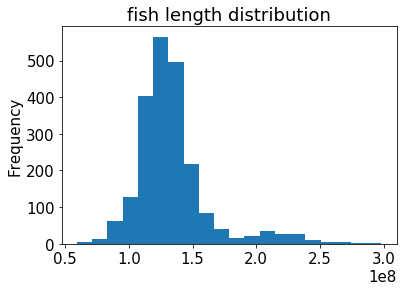

In [63]:
has_depth_and_distance['pixel length'] = None
has_depth_and_distance['pixel length'][horizontal] = has_depth_and_distance[IMAGE_WIDTH]
has_depth_and_distance['pixel length'][vertical] = has_depth_and_distance[IMAGE_HEIGHT]
has_depth_and_distance['pixel length'][diagonal] = np.sqrt((has_depth_and_distance[IMAGE_HEIGHT]**2) + (has_depth_and_distance[IMAGE_WIDTH]**2))
has_depth_and_distance['fish length'] = (has_depth_and_distance['pixel length'] * (has_depth_and_distance['distance_from_camera']*1000)) / has_depth_and_distance['camera_metadata__focalLength']
pd.Series(has_depth_and_distance['fish length'].astype(np.float64)).plot.hist(bins=20, title='fish length distribution')

Pen:57
{'explained_variance_score': -0.1258043906939763, 'mean_absolute_error': 0.05866019407367167}
Pen:59
{'explained_variance_score': -0.13394022121220917, 'mean_absolute_error': 0.07843708280844179}
Pen:56
{'explained_variance_score': -0.041494449538558964, 'mean_absolute_error': 0.06439054705442043}
Pen:60
{'explained_variance_score': -0.13322153554307747, 'mean_absolute_error': 0.05938778189940166}
Pen:58
{'explained_variance_score': -0.012800963136538668, 'mean_absolute_error': 0.056131299868861645}
Pen:65
{'explained_variance_score': 0.27279188989841796, 'mean_absolute_error': 0.10952900928651191}
Pen:72
{'explained_variance_score': 0.3393230194736143, 'mean_absolute_error': 0.36405345285397367}
Pen:37
{'explained_variance_score': 0.10068072722868437, 'mean_absolute_error': 0.31930099240015825}
Pen:75
{'explained_variance_score': -0.6464589363560069, 'mean_absolute_error': 0.1429711734133863}


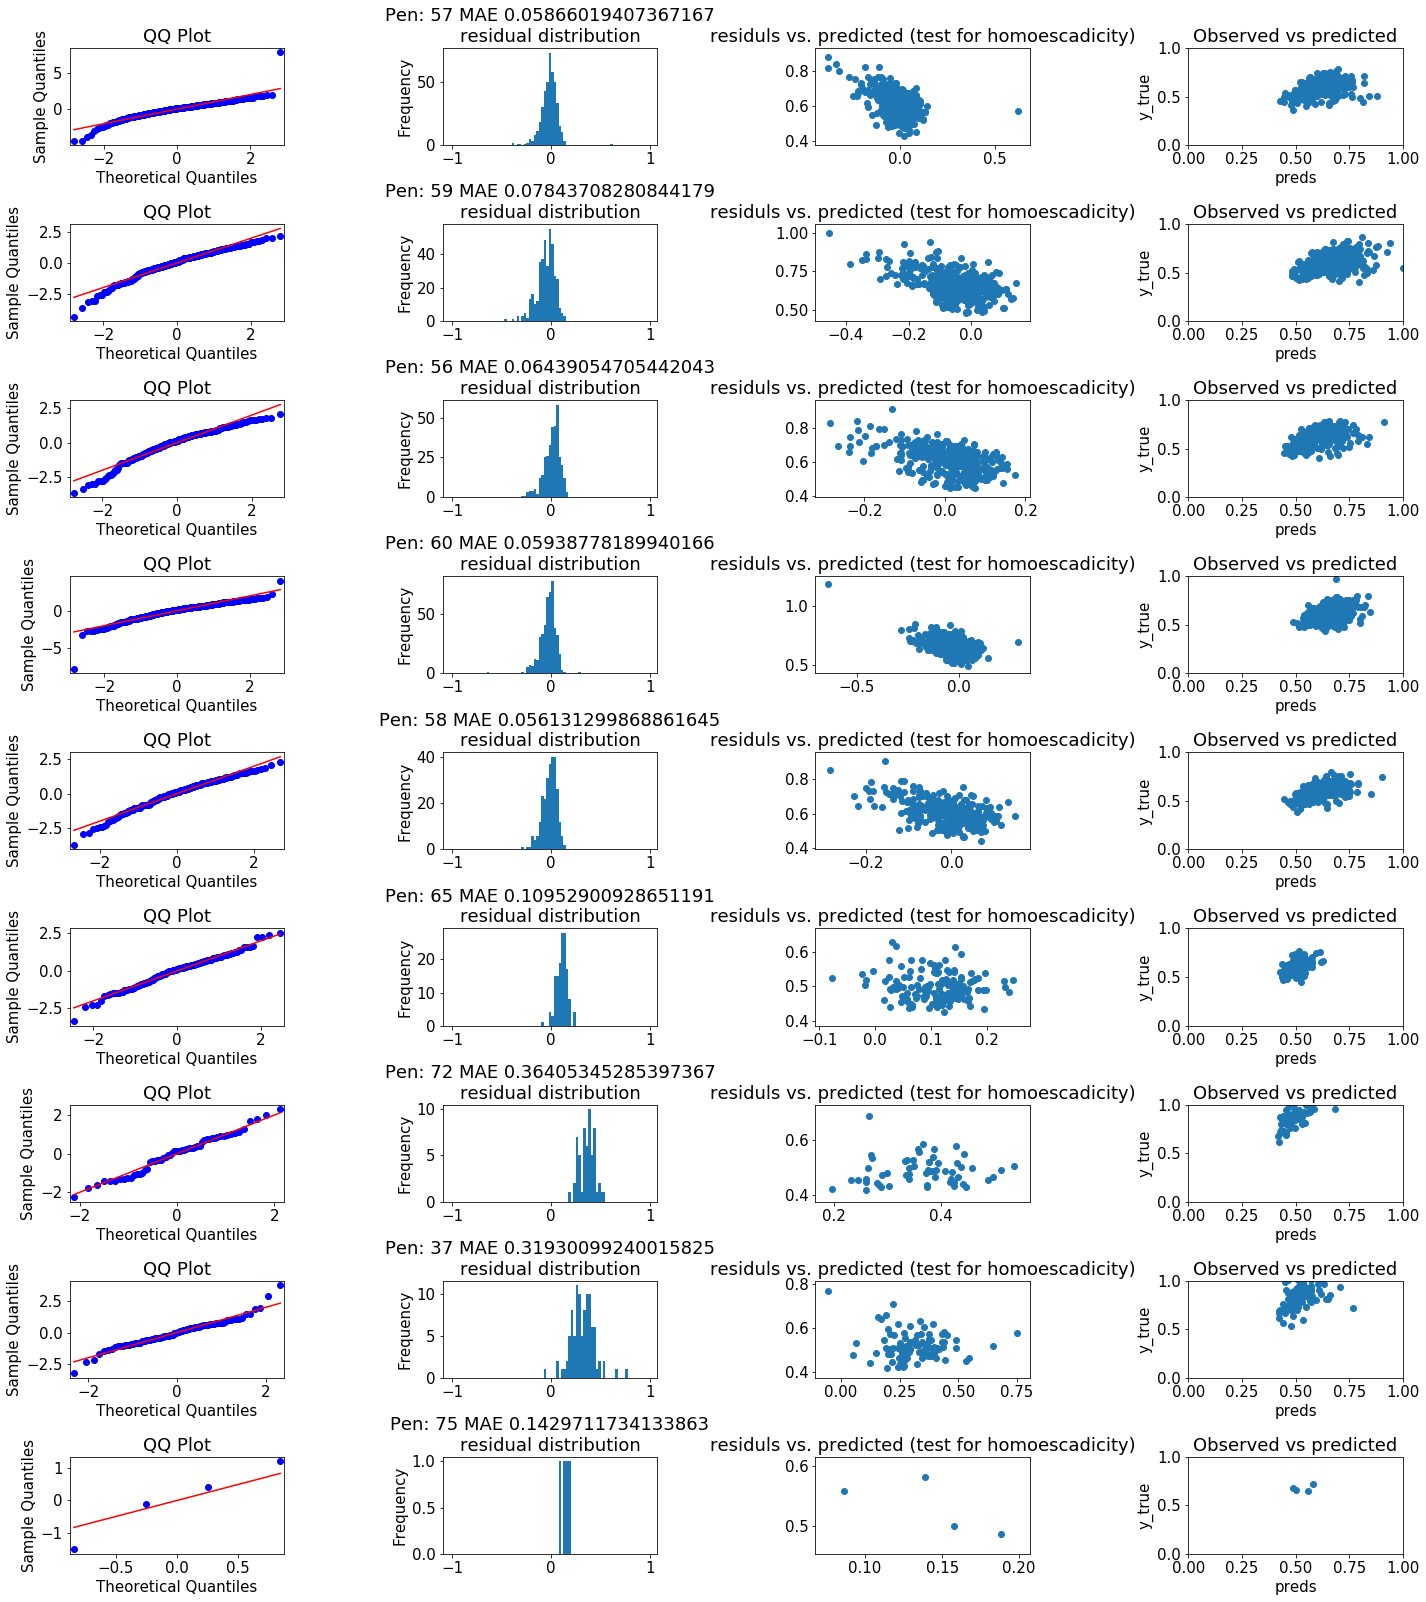

In [64]:
fish_length_median = has_depth_and_distance['fish length'].median()
has_depth_and_distance['new depth estimate'] = (has_depth_and_distance['camera_metadata__focalLength'] * fish_length_median) / has_depth_and_distance['pixel length']

results = dict()
for pen in has_depth_and_distance.pen_id.unique():
    this_pen_df = has_depth_and_distance[pdf.pen_id==pen]
    y_true, y_pred = this_pen_df.distance_from_camera, this_pen_df['new depth estimate'] / 1000
    try:
        assert y_true.isnull().sum() == 0
        assert y_pred.isnull().sum() == 0, str(y_pred.notnull().value_counts())
        results[pen] = get_performance_report(y_true, y_pred)
        print(f'Pen:{pen}')
        print(results[pen]['evaluation'])
    except Exception as e:
        print(e)

plot_results(results, is_model=False)

This estimate is much better, which confirms that degradation is the issue with depth_Mm

## Linear model for Area from left crop

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/statsmodels/graphics/gofplots.py:235: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


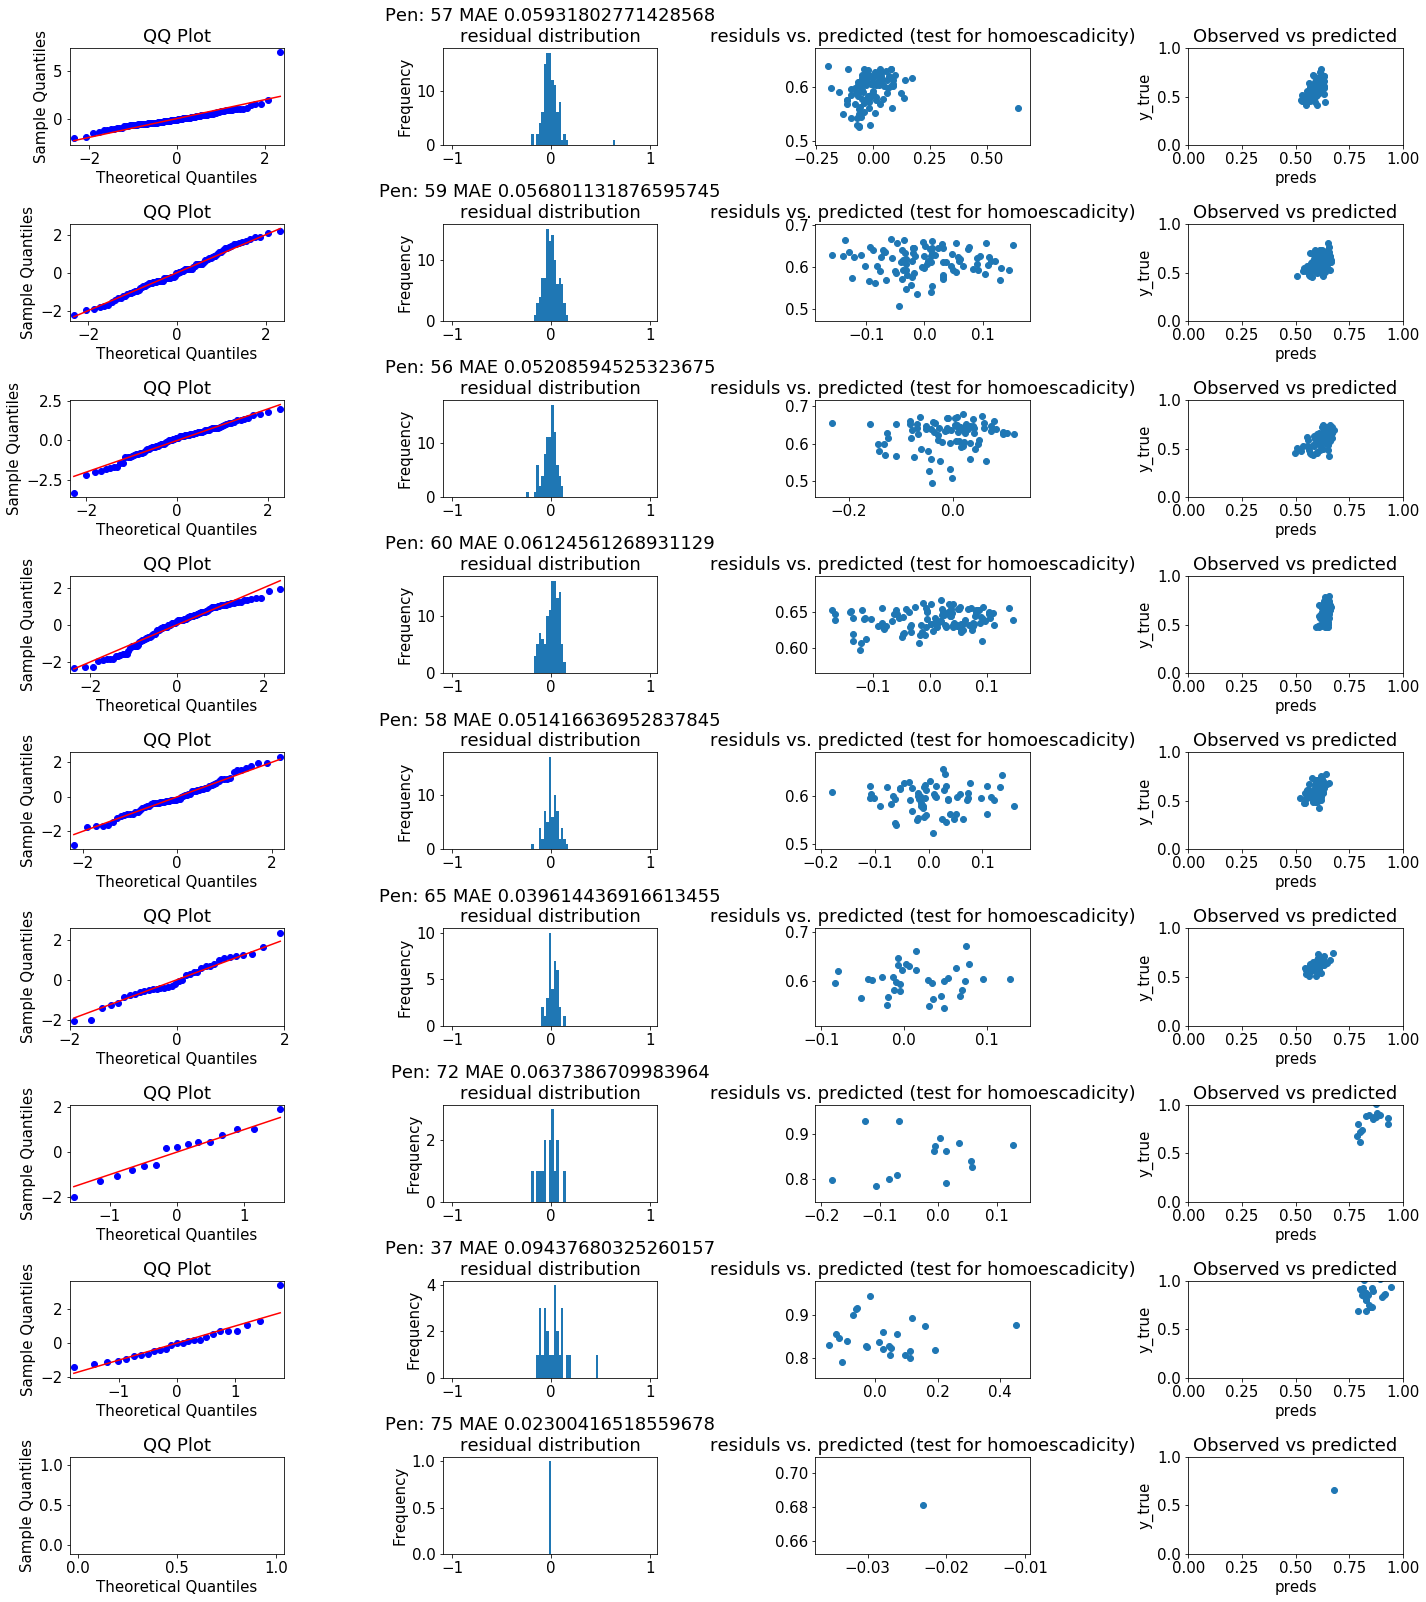

In [66]:
report = evaluate(LinearRegression, ['left_crop_metadata__crop_area'])
plot_results(report, is_model=False)

## Linear model for Area from both crops

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/statsmodels/graphics/gofplots.py:235: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


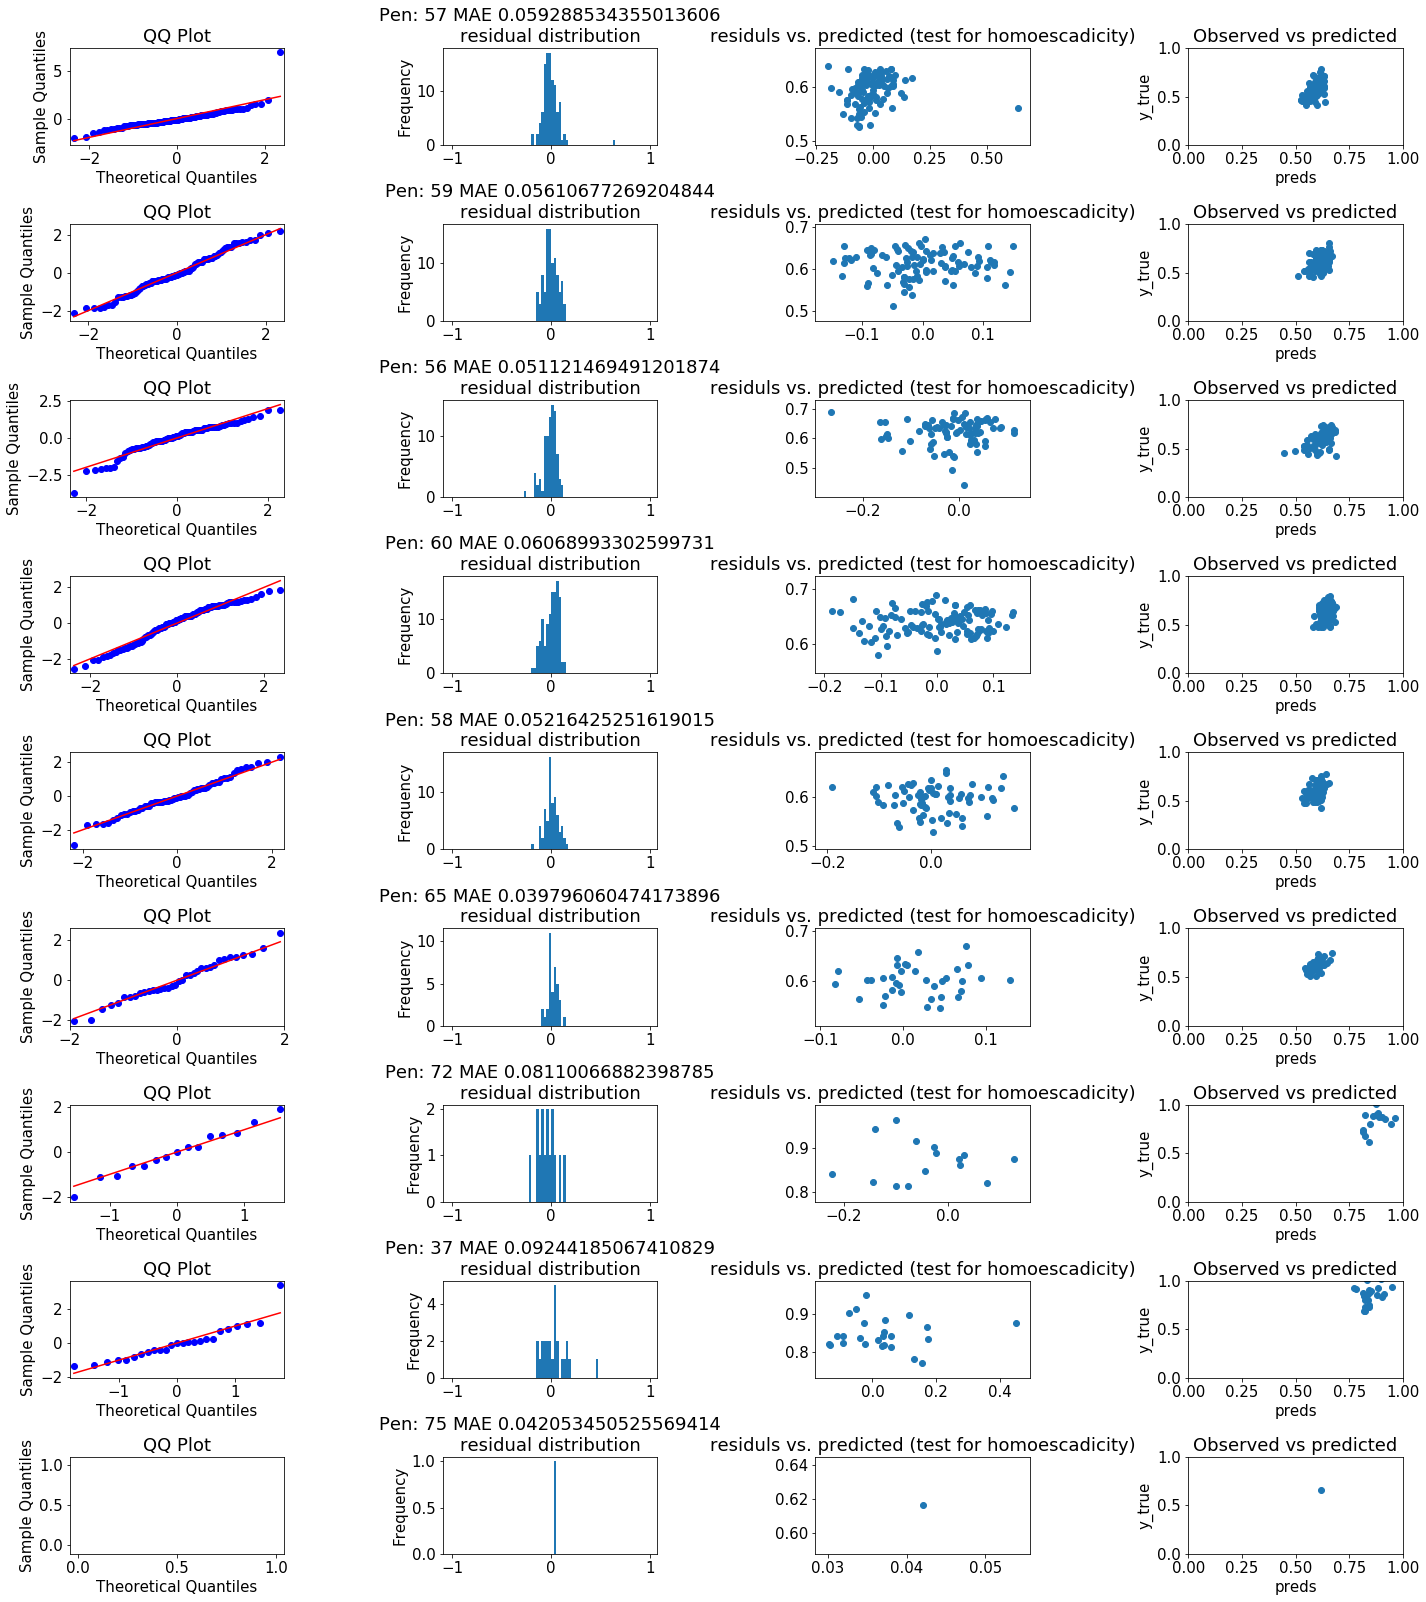

In [67]:
report = evaluate(LinearRegression, ['left_crop_metadata__crop_area', 'right_crop_metadata__crop_area'])
plot_results(report, is_model=False)

## Dimension left crop Features

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/statsmodels/graphics/gofplots.py:235: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


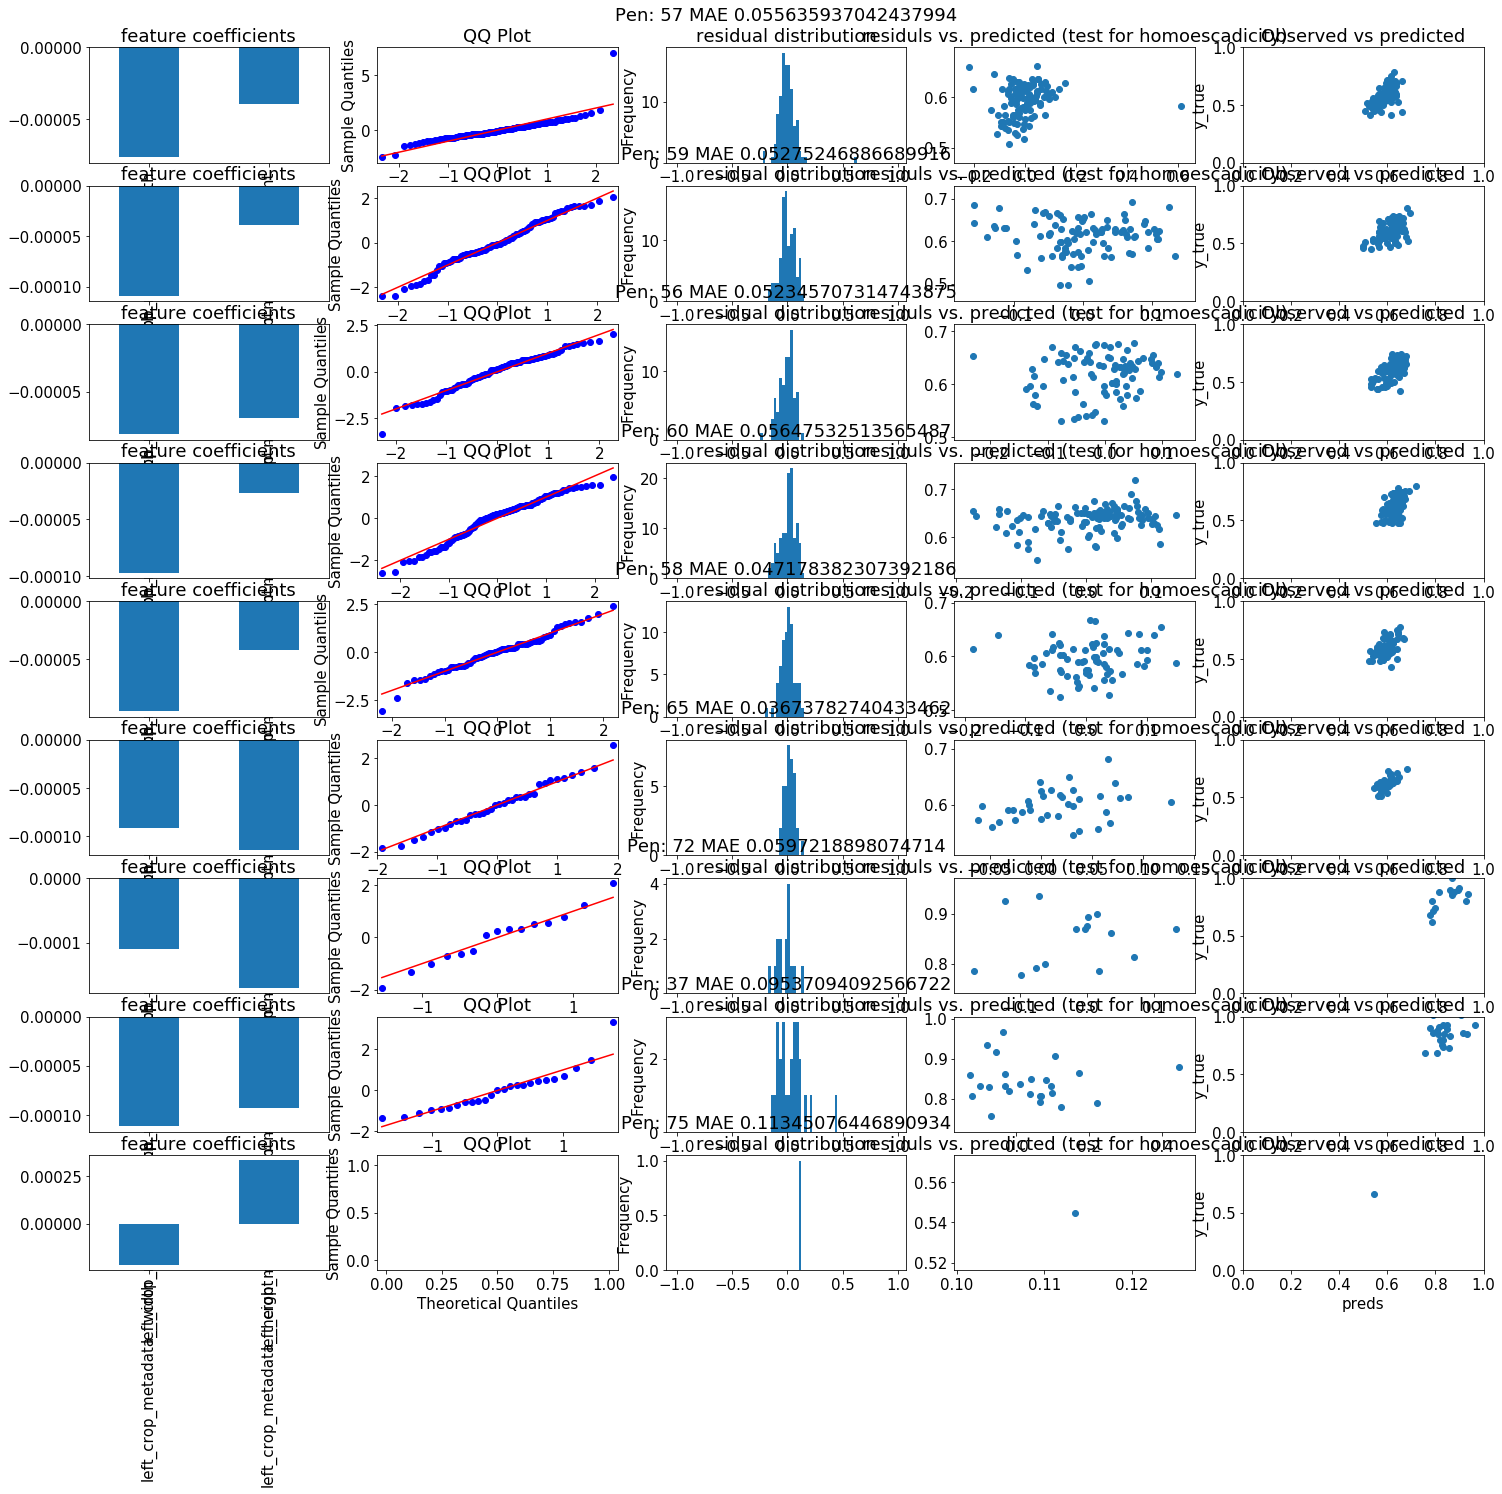

In [69]:
report = evaluate(LinearRegression, ['left_crop_metadata__width', 'left_crop_metadata__height'])
plot_results(report)
plt.tight_layout()

## Both side dimension

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/statsmodels/graphics/gofplots.py:235: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


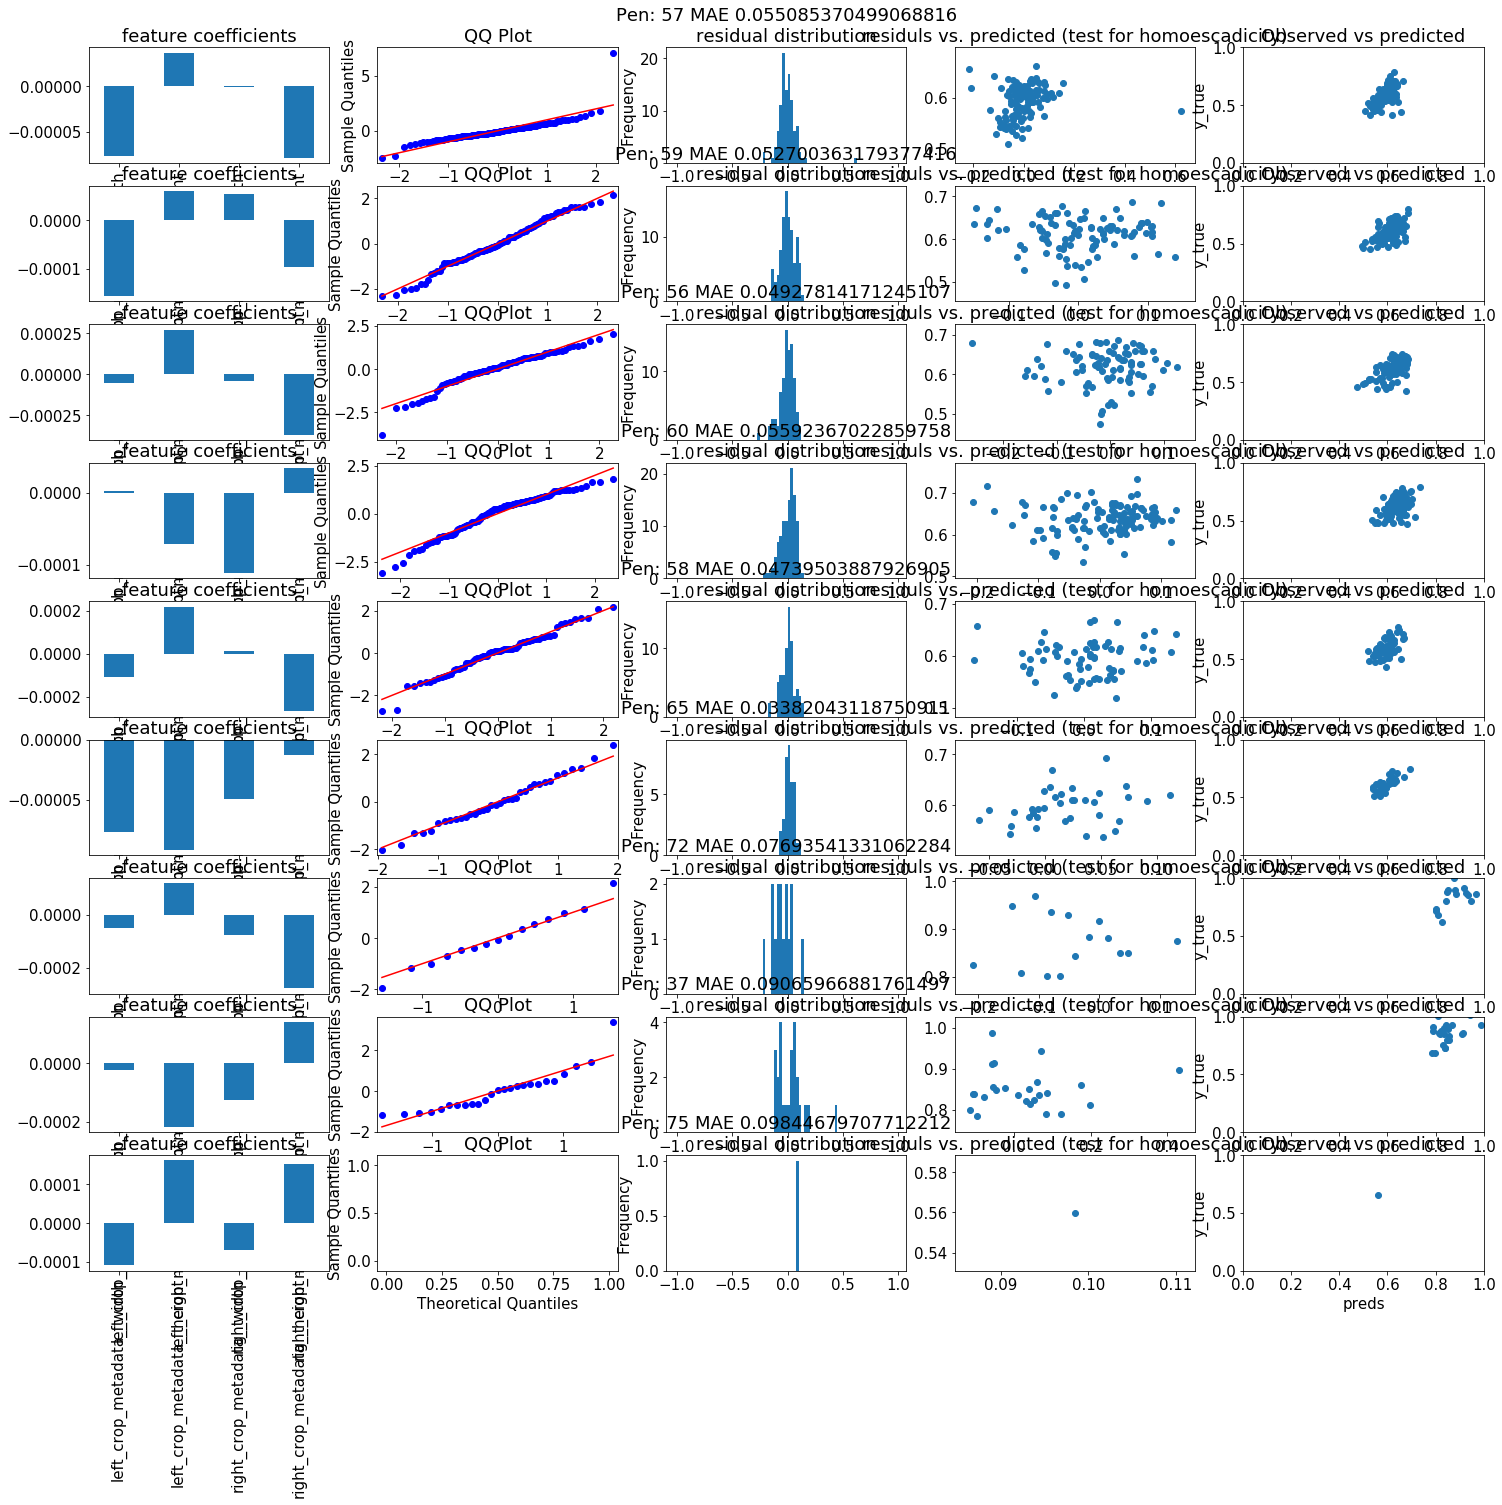

In [70]:
report = evaluate(LinearRegression, ['left_crop_metadata__width', 'left_crop_metadata__height', 'right_crop_metadata__width', 'right_crop_metadata__height'])
plot_results(report)
plt.tight_layout()

## Area + Dimension Features

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/statsmodels/graphics/gofplots.py:235: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


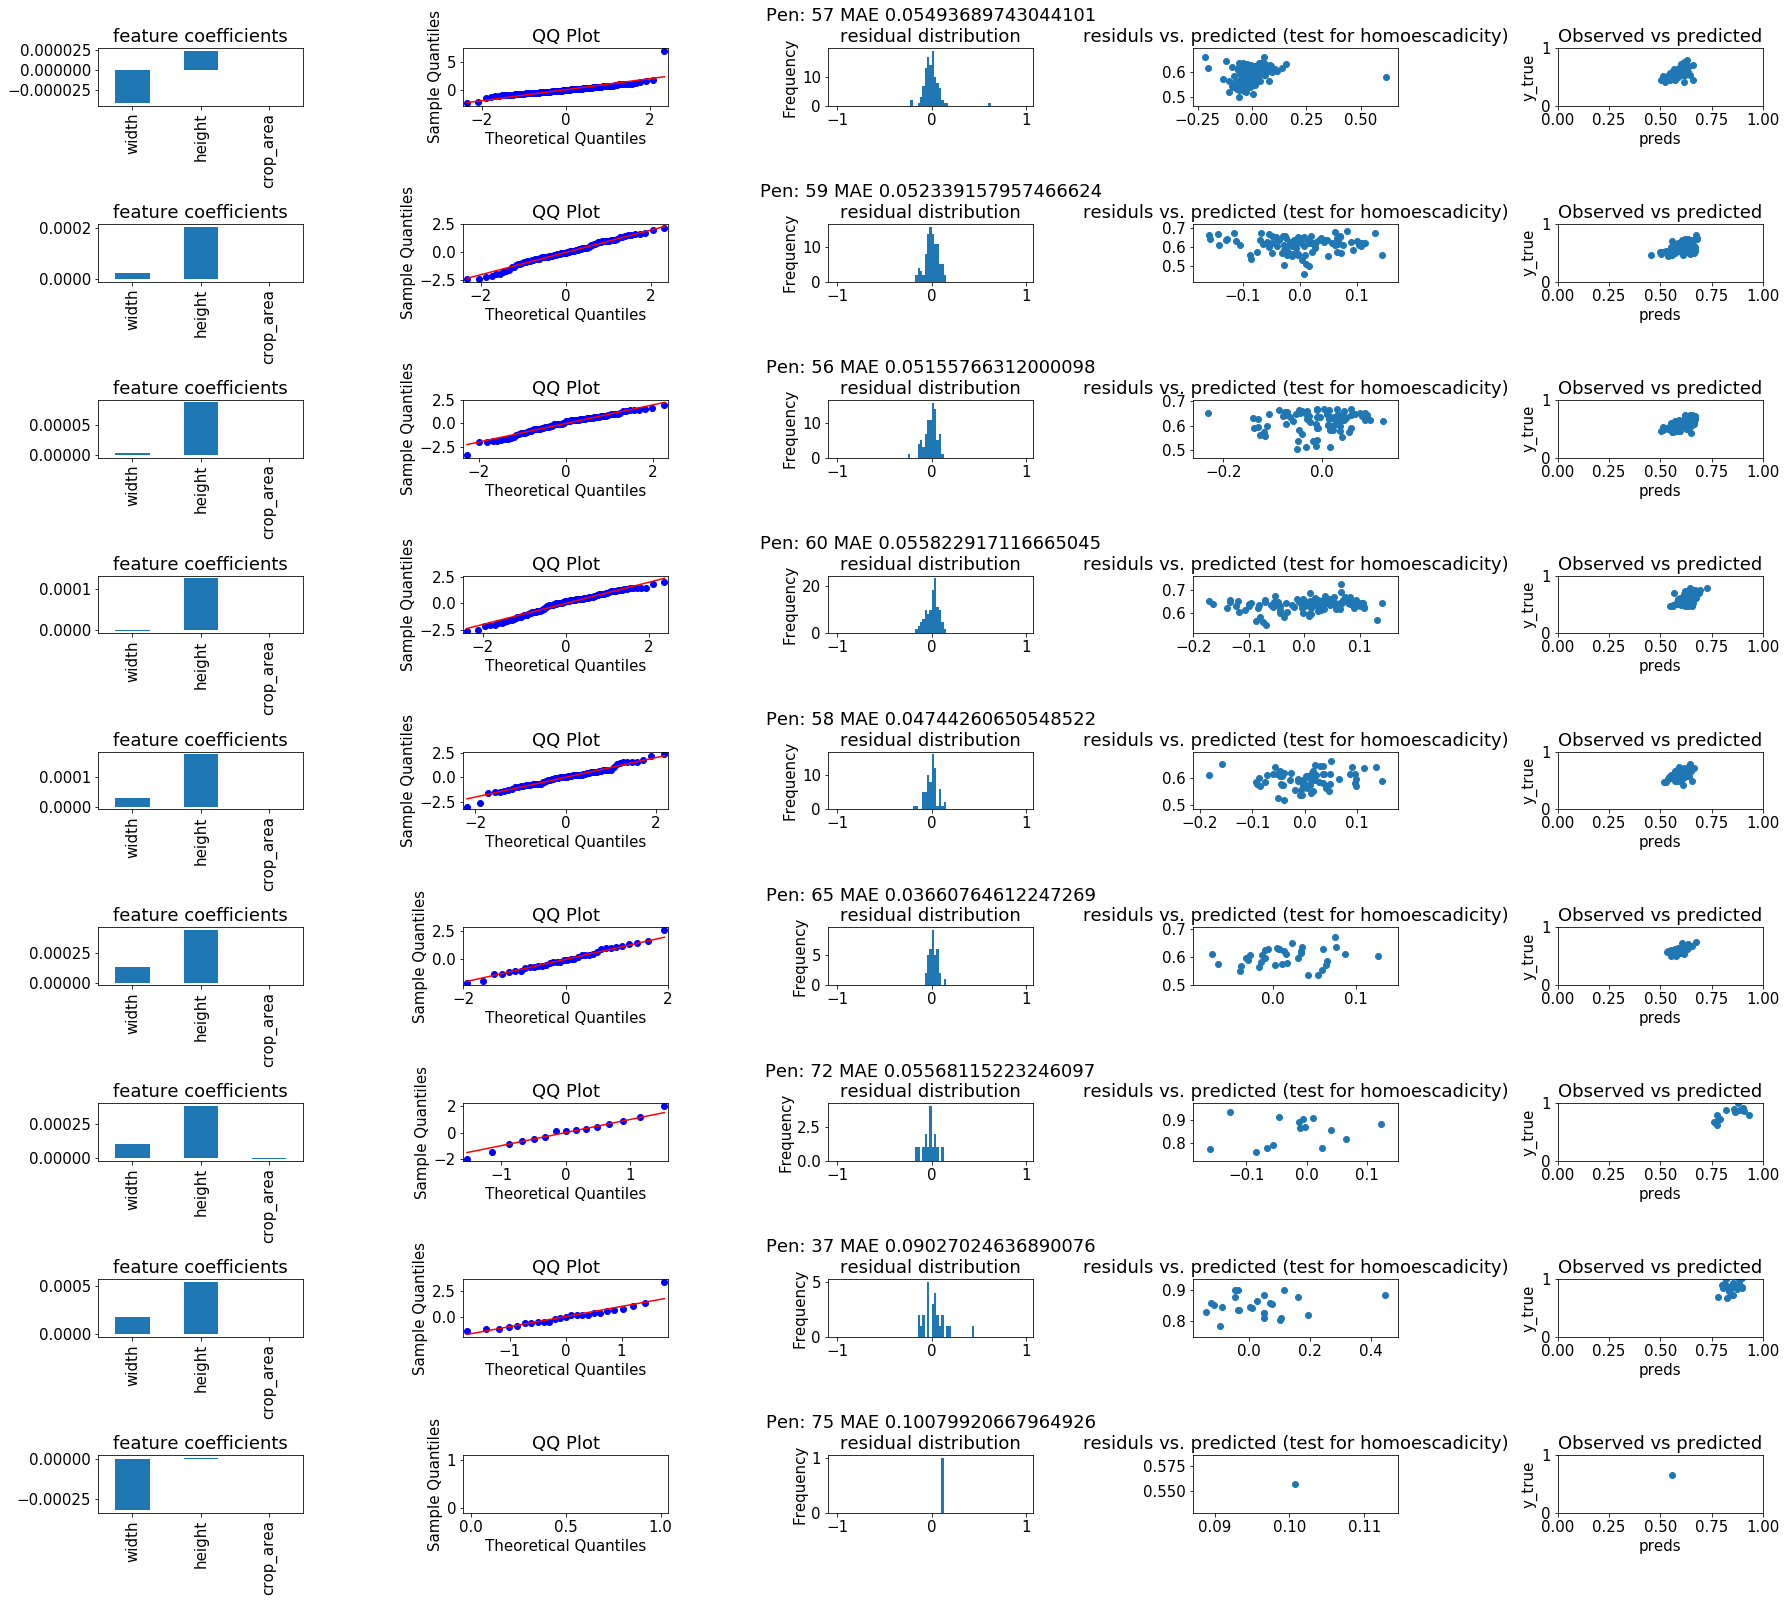

In [40]:
report = evaluate(LinearRegression, dimension_features + ['crop_area'])
plot_results(report)

### Backtesting for production

In [1]:
!ls weekly/

2019-11-04 2019-11-11 2019-11-18 2019-11-25 2019-12-02


In [37]:
import pandas as pd
import os

weekly_depths = dict()
weeks = os.listdir('weekly/')
for week in weeks:
    parquet_paths = [p for p in os.listdir(f'weekly/{week}/') if p.endswith('.parquet')]
    assert len(parquet_paths) == 1, parquet_paths
    parquet_path = os.path.join('weekly', week, parquet_paths[0])
    weekly_depths[week] = pd.read_parquet(parquet_path)
    
weekly_depths.keys()

dict_keys(['2019-11-18', '2019-11-11', '2019-11-04', '2019-11-25', '2019-12-02'])

In [68]:
import json

all_pens = set()

for w in weekly_depths:
    pdf = weekly_depths[w]
    all_pens.update(list(pdf['pen_id'].unique()))
    df_col = 'left_crop_metadata'
    pdf = pdf[pdf[df_col].apply(type) == str]
    expanded = pdf[df_col].apply(json.loads).apply(pd.Series)
    for key in expanded.columns:
        expanded[df_col + '__' + key] = expanded[key]
        expanded.drop(key, inplace=True, axis=1)
    na_cols = []
    for col in expanded:
        if expanded[col].isnull().sum() > 0:
            print(col + ' is null')
            print(expanded[col].isnull().value_counts())
    expanded.index = pdf.index
    pdf = pdf.merge(expanded)
    pdf = pdf[pdf['left_crop_metadata__depth_mm'].notnull()]
    weekly_depths[w] = pdf

left_crop_metadata__depth_mm is null
False    473
True     260
Name: left_crop_metadata__depth_mm, dtype: int64
left_crop_metadata__depth_mm is null
False    1740
True      327
Name: left_crop_metadata__depth_mm, dtype: int64
left_crop_metadata__depth_mm is null
False    1961
True      211
Name: left_crop_metadata__depth_mm, dtype: int64
left_crop_metadata__depth_mm is null
False    1897
True      131
Name: left_crop_metadata__depth_mm, dtype: int64
left_crop_metadata__depth_mm is null
False    2209
True      156
Name: left_crop_metadata__depth_mm, dtype: int64


In [72]:
all_pens

{37, 56, 57, 58, 59, 60, 64, 65, 66, 69, 72, 73, 75}

## Eval each weeks model on the next week

In [84]:
all_pens = [37, 56, 57, 58, 59, 60]




week:2019-11-04 pen:37
Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
       'annotation_state_id', 'distance_from_camera',
       'left_crop_metadata__width', 'left_crop_metadata__height',
       'left_crop_metadata__x_coord', 'left_crop_metadata__y_coord',
       'left_crop_metadata__depth_mm', 'left_crop_metadata__crop_area',
       'left_crop_metadata__quality_score',
       'left_crop_metadata__mean_luminance',
       'left_crop_metadata__edge_detection_score',
       'left_crop_metadata__mean_green_luminance'],
      dtype='object')
Baseline
{'explained_variance_score': 0.16195412251379848, 'mean_absolute_error': 0.21010422055295855}
Model
{'explained_variance_score': -0.09987885165507016, 'mean_absolute_error': 0.25591974178406696}



week:2019-11-04 pen:56
Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',




week:2019-11-18 pen:37
Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
       'annotation_state_id', 'distance_from_camera',
       'left_crop_metadata__width', 'left_crop_metadata__height',
       'left_crop_metadata__x_coord', 'left_crop_metadata__y_coord',
       'left_crop_metadata__depth_mm', 'left_crop_metadata__crop_area',
       'left_crop_metadata__quality_score',
       'left_crop_metadata__mean_luminance',
       'left_crop_metadata__edge_detection_score',
       'left_crop_metadata__mean_green_luminance'],
      dtype='object')
Baseline
{'explained_variance_score': 0.2598159353710987, 'mean_absolute_error': 0.23338077945761426}
Model
{'explained_variance_score': -0.24357833665923234, 'mean_absolute_error': 0.1860875080739172}



week:2019-11-18 pen:56
Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
 




week:2019-11-25 pen:60
Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
       'annotation_state_id', 'distance_from_camera',
       'left_crop_metadata__width', 'left_crop_metadata__height',
       'left_crop_metadata__x_coord', 'left_crop_metadata__y_coord',
       'left_crop_metadata__depth_mm', 'left_crop_metadata__crop_area',
       'left_crop_metadata__quality_score',
       'left_crop_metadata__mean_luminance',
       'left_crop_metadata__edge_detection_score',
       'left_crop_metadata__mean_green_luminance'],
      dtype='object')
Baseline
{'explained_variance_score': 0.3068329719952577, 'mean_absolute_error': 0.23453893022685265}
Model
{'explained_variance_score': 0.07837047101367534, 'mean_absolute_error': 0.06891849615822497}


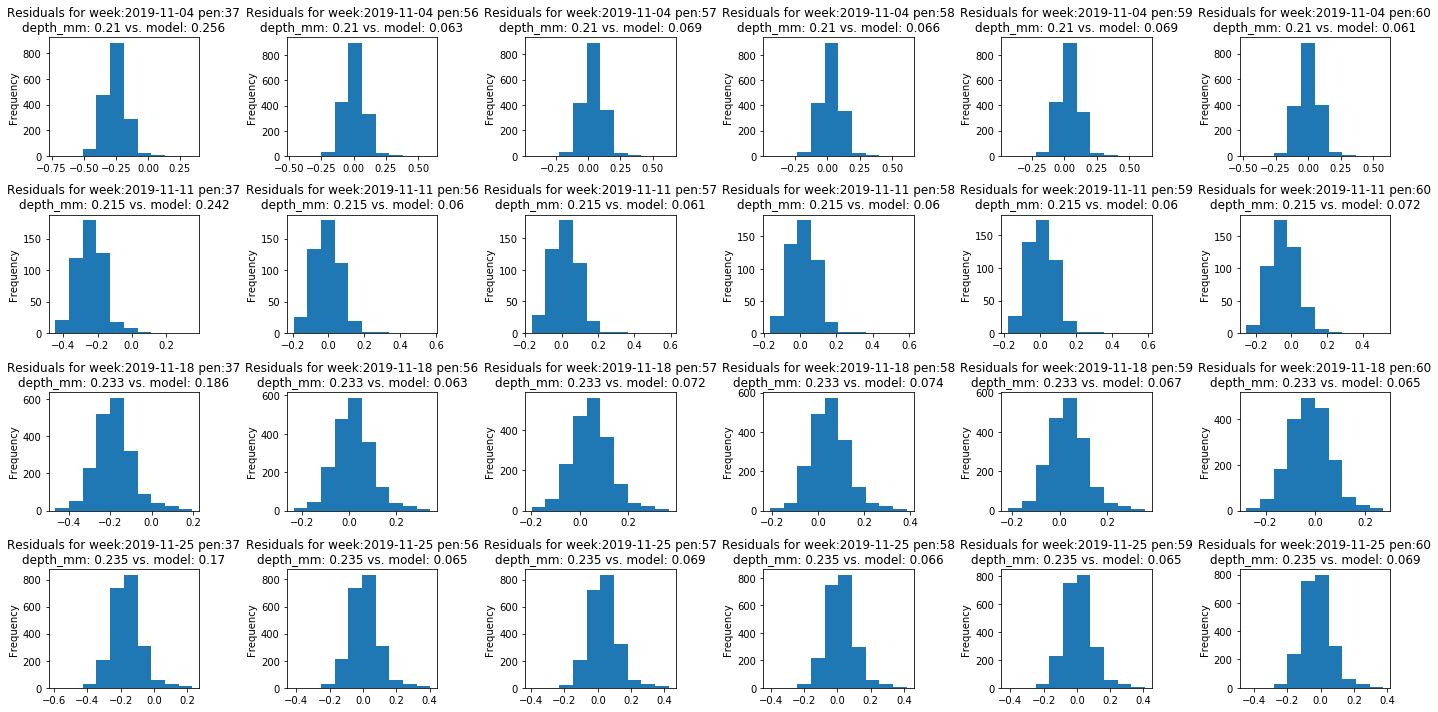

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=len(weeks)-1, ncols=len(all_pens), figsize=(20, 10))

metrics = [explained_variance_score, mean_absolute_error]
weeks = sorted(weeks)

def get_report(gold, preds):
    report = {'evaluation': {m.__name__: m(gold, preds) for m in metrics}}
    report['preds'] = preds
    report['gold'] = gold
    report['residuals'] = gold - preds
    return report

for i, w in enumerate(weeks[:-1]):
    this_week = weekly_depths[weeks[i]]
    this_week = this_week[this_week['left_crop_metadata__depth_mm'].notnull()]
    next_week = weekly_depths[weeks[i+1]]
    next_week = next_week[next_week['left_crop_metadata__depth_mm'].notnull()]
    for j, p in enumerate(all_pens):
        this_week_pen = this_week[this_week['pen_id'] == p]
        next_week_pen = next_week[next_week['pen_id'] == p]
        if len(this_week_pen) > 10:
            x, y = np.array([this_week_pen['left_crop_metadata__crop_area']]).T, this_week_pen['distance_from_camera']
            model = LinearRegression(normalize=True)
            model.fit(x, y)
            next_x = np.array([next_week['left_crop_metadata__crop_area']]).T
            preds = model.predict(next_x)
            gold = next_week['distance_from_camera']
            print('\n\n\n' + f'week:{w} pen:{p}')
            print(next_week.columns)
            baseline_report = get_report(gold, next_week['left_crop_metadata__depth_mm']/1000)
            model_report = get_report(gold, preds)
            print('Baseline')
            print(baseline_report['evaluation'])
            print('Model')
            print(model_report['evaluation'])
            b = round(baseline_report['evaluation']['mean_absolute_error'], 3)
            m = round(model_report['evaluation']['mean_absolute_error'], 3)
            scores = f"depth_mm: {b} vs. model: {m}"
            model_report['residuals'].plot.hist(ax=axes[i][j], title=f'Residuals for week:{w} pen:{p}\n{scores}')
        else:
            print(f'Skipping {p}')
plt.tight_layout()

## Conclusion

We find that all of the above models perform significantly better than our baseline, and that the best model use either crop_area, or the coordinates, implying that the simple area of the fish in the image is the most important factor for determining depth. As a result, we recommend a linear regression model that uses the crop_area as input for to replace the existing solution for depth estimation in production